In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams

In [7]:
# load train and test data
rossman_store_train = pd.read_csv('./data/train.csv', parse_dates='Date')
rossman_store_test = pd.read_csv('./data/test.csv', parse_dates='Date')

In [8]:
rossman_store_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 77.6+ MB


In [9]:
rossman_store_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.8+ MB


In [10]:
# take a look at the data
rossman_store_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
# take a look at test data
rossman_store_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [63]:
#Plotting mean sales for every store

data = rossman_store_train[['Store', 'DayOfWeek', 'Sales']]
data = data.convert_objects(convert_numeric=True)

In [64]:
# take median of sales grouped by store and day of week
medians = data.groupby(['Store','DayOfWeek']).median().dropna()
medians.head()

Sales
Store DayOfWeek       
1     1           5140
      2           4633
      3           4383
      4           4293
      5           4609

In [65]:
# take mean of sales grouped by store and day of week
means = data.groupby(['Store', 'DayOfWeek']).mean().dropna()
means.head()

Sales
Store DayOfWeek             
1     1          4946.119403
      2          4650.918519
      3          4454.474074
      4          4094.607407
      5          4516.414815

In [74]:
# unstack to see the distribution of as to 
# see sales of various stores on different days of week

medians.unstack(1).head()

Sales                                   
DayOfWeek        1     2     3     4     5       6  7
Store                                                
1           5140.0  4633  4383  4293  4609  4785.0  0
2           6506.0  5450  5830  4950  4608  2735.0  0
3           8861.0  7895  7417  6701  6933  4214.5  0
4          10988.0  9583  8860  8763  9299  9918.5  0
5           6610.5  5183  5261  4692  4764  2009.5  0

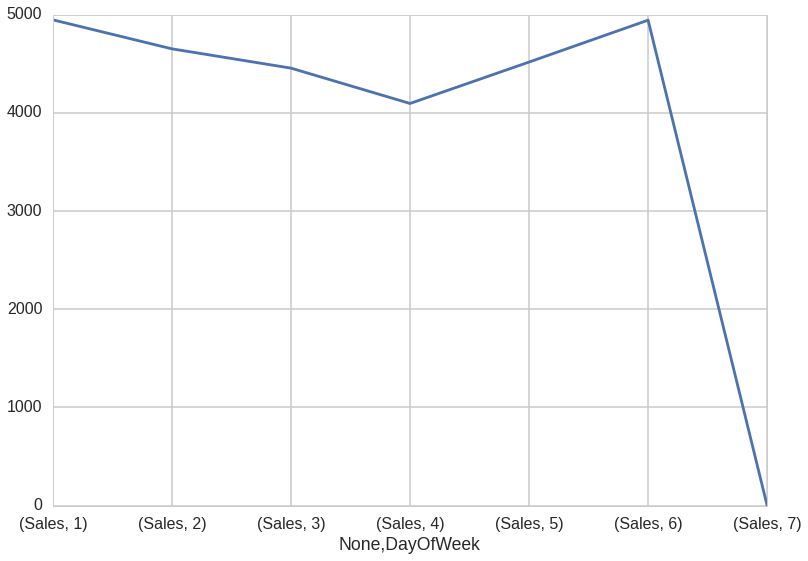

In [75]:
means.unstack(1).ix[1].plot();

In [76]:
# unstack to see the distribution of as to 
# see sales of various stores on different days of week

means.unstack(1).head()

Sales                                                      \
DayOfWeek             1            2            3            4            5   
Store                                                                         
1           4946.119403  4650.918519  4454.474074  4094.607407  4516.414815   
2           5790.522388  5329.429630  5705.281481  4673.103704  4462.051852   
3           7965.029851  7588.214815  6973.688889  6371.244444  6820.222222   
4          10365.686567  9340.200000  8721.762963  8535.222222  9049.503704   
5           5834.880597  5071.844444  5019.044444  4431.429630  4606.155556   

                            
DayOfWeek             6  7  
Store                       
1           4942.970149  0  
2           2873.104478  0  
3           4434.641791  0  
4          10113.447761  0  
5           2079.104478  0

In [ ]:
means.unstack(1).ix[1].plot();

## Basic Model

** Predict mean of sales of stores till date as prediction for next weeks **

In [60]:
predictions = median_grouped_by_day_of_week.ix[rossman_store_test.Store.values]

In [61]:
ids = rossman_store_test.Id.values

In [62]:
submission_df = pd.DataFrame({'Id': ids, 'Sales': predictions})
submission_df.to_csv('./submissions/median_prediction_by_day_of_week.csv', index=False)